In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]
print(to_explain.shape)

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:522: FutureWarn

(2, 224, 224, 3)


In [9]:
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
print(map2layer(to_explain, 7).shape)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

(2, 56, 56, 128)


In [11]:
len(shap_values), shap_values[0].shape, shap_values[1].shape

((2, 56, 56, 128), (2, 56, 56, 128))

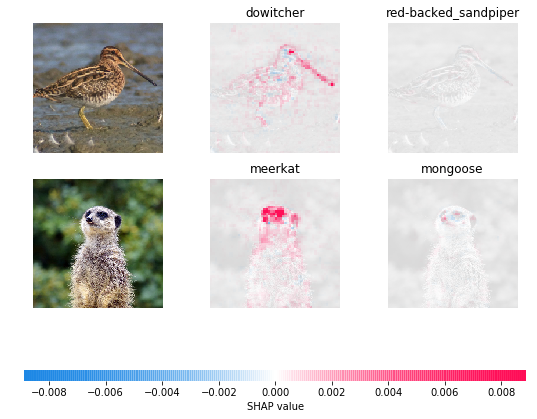

In [24]:
shap.image_plot(shap_values, to_explain, index_names)

In [15]:
labels = index_names

# make sure labels
multi_output = True
if labels is not None:
    assert labels.shape[0] == shap_values[0].shape[0], "Labels must have same row count as shap_values arrays!"
    if multi_output:
        assert labels.shape[1] == len(shap_values), "Labels must have a column for each output in shap_values!"
    else:
        assert len(labels.shape) == 1, "Labels must be a vector for single output shap_values."

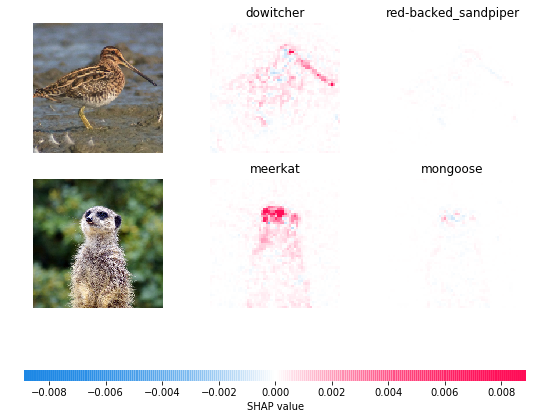

In [31]:
from shap.plots import colors
import matplotlib.pyplot as pl
%matplotlib inline

x = to_explain
show=True
width=20
aspect=0.2
hspace=0.2
labelpad=None
label_kwargs = {} if labelpad is None else {'pad': labelpad}

# plot our explanations
fig_size = np.array([3 * (len(shap_values) + 1), 2.5 * (x.shape[0] + 1)])
if fig_size[0] > width:
    fig_size *= width / fig_size[0]
fig, axes = pl.subplots(nrows=x.shape[0], ncols=len(shap_values) + 1, figsize=fig_size)
if len(axes.shape) == 1:
    axes = axes.reshape(1,axes.size)
for row in range(x.shape[0]):
    x_curr = x[row].copy()

    # make sure
    if len(x_curr.shape) == 3 and x_curr.shape[2] == 1:
        x_curr = x_curr.reshape(x_curr.shape[:2])
    if x_curr.max() > 1:
        x_curr /= 255.

    # get a grayscale version of the image
    if len(x_curr.shape) == 3 and x_curr.shape[2] == 3:
        x_curr_gray = (0.2989 * x_curr[:,:,0] + 0.5870 * x_curr[:,:,1] + 0.1140 * x_curr[:,:,2]) # rgb to gray
    else:
        x_curr_gray = x_curr

    axes[row,0].imshow(x_curr, cmap=pl.get_cmap('gray'))
    axes[row,0].axis('off')
    if len(shap_values[0][row].shape) == 2:
        abs_vals = np.stack([np.abs(shap_values[i]) for i in range(len(shap_values))], 0).flatten()
    else:
        abs_vals = np.stack([np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0).flatten()
    max_val = np.nanpercentile(abs_vals, 99.9)
    for i in range(len(shap_values)):
        if labels is not None:
            axes[row,i+1].set_title(labels[row,i], **label_kwargs)
        sv = shap_values[i][row] if len(shap_values[i][row].shape) == 2 else shap_values[i][row].sum(-1)
        #axes[row,i+1].imshow(x_curr_gray, cmap=pl.get_cmap('gray'), alpha=0.15, extent=(-1, sv.shape[0], sv.shape[1], -1))
        im = axes[row,i+1].imshow(sv, cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
        axes[row,i+1].axis('off')
if hspace == 'auto':
    fig.tight_layout()
else:
    fig.subplots_adjust(hspace=hspace)
cb = fig.colorbar(im, ax=np.ravel(axes).tolist(), label="SHAP value", orientation="horizontal", aspect=fig_size[0]/aspect)
cb.outline.set_visible(False)
if show:
    pl.show()

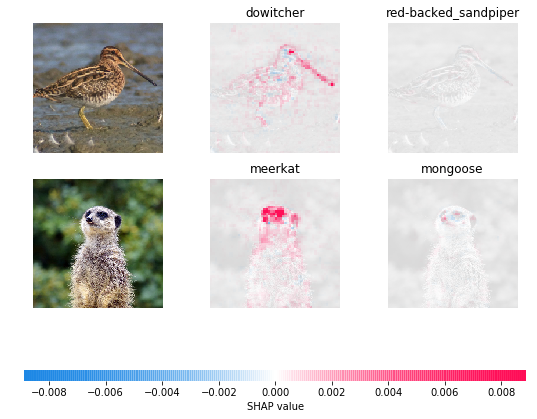

In [30]:
from shap.plots import colors
import matplotlib.pyplot as pl
%matplotlib inline

x = to_explain
show=True
width=20
aspect=0.2
hspace=0.2
labelpad=None
label_kwargs = {} if labelpad is None else {'pad': labelpad}

# plot our explanations
fig_size = np.array([3 * (len(shap_values) + 1), 2.5 * (x.shape[0] + 1)])
if fig_size[0] > width:
    fig_size *= width / fig_size[0]
fig, axes = pl.subplots(nrows=x.shape[0], ncols=len(shap_values) + 1, figsize=fig_size)
if len(axes.shape) == 1:
    axes = axes.reshape(1,axes.size)
for row in range(x.shape[0]):
    x_curr = x[row].copy()

    # make sure
    if len(x_curr.shape) == 3 and x_curr.shape[2] == 1:
        x_curr = x_curr.reshape(x_curr.shape[:2])
    if x_curr.max() > 1:
        x_curr /= 255.

    # get a grayscale version of the image
    if len(x_curr.shape) == 3 and x_curr.shape[2] == 3:
        x_curr_gray = (0.2989 * x_curr[:,:,0] + 0.5870 * x_curr[:,:,1] + 0.1140 * x_curr[:,:,2]) # rgb to gray
    else:
        x_curr_gray = x_curr

    axes[row,0].imshow(x_curr, cmap=pl.get_cmap('gray'))
    axes[row,0].axis('off')
    if len(shap_values[0][row].shape) == 2:
        abs_vals = np.stack([np.abs(shap_values[i]) for i in range(len(shap_values))], 0).flatten()
    else:
        abs_vals = np.stack([np.abs(shap_values[i].sum(-1)) for i in range(len(shap_values))], 0).flatten()
    max_val = np.nanpercentile(abs_vals, 99.9)
    for i in range(len(shap_values)):
        if labels is not None:
            axes[row,i+1].set_title(labels[row,i], **label_kwargs)
        sv = shap_values[i][row] if len(shap_values[i][row].shape) == 2 else shap_values[i][row].sum(-1)
        axes[row,i+1].imshow(x_curr_gray, cmap=pl.get_cmap('gray'), alpha=0.15, extent=(-1, sv.shape[0], sv.shape[1], -1))
        im = axes[row,i+1].imshow(sv, cmap=colors.red_transparent_blue, vmin=-max_val, vmax=max_val)
        axes[row,i+1].axis('off')
if hspace == 'auto':
    fig.tight_layout()
else:
    fig.subplots_adjust(hspace=hspace)
cb = fig.colorbar(im, ax=np.ravel(axes).tolist(), label="SHAP value", orientation="horizontal", aspect=fig_size[0]/aspect)
cb.outline.set_visible(False)
if show:
    pl.show()